<a href="https://colab.research.google.com/github/lrav35/diffusion/blob/main/QuickDiffusionModel_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import custom_object_scope
from google.colab import drive
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 64
FIG_SIZE = (5, 5)
categories = [5, 6, 7]  # dog, frogs, horses
timesteps = 32
num_images = 25
time_bar = 1 - np.linspace(0, 1., timesteps + 1)

In [3]:
# load data and split into train and test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_idx = []
test_idx = []
for i, cat in enumerate(y_train.squeeze()):
  if cat in categories:
    train_idx.append(i)
for i, cat in enumerate(y_test.squeeze()):
  if cat in categories:
    test_idx.append(i)
X_train = X_train[train_idx]
y_train = y_train[train_idx] - 5
# Reduces the test size by 3 to 1000
X_test = X_test[test_idx][:len(test_idx)//3]
y_test = y_test[test_idx][:len(test_idx)//3] - 5
X_train = X_train / 127.5 - 1.0  # scale to -1 to 1
X_test = X_test / 127.5 - 1.0

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of X_test:", y_test.shape)

Size of X_train: (15000, 32, 32, 3)
Size of X_test: (1000, 32, 32, 3)
Size of X_test: (1000, 1)


In [5]:
# functions for viewing images
def show_examples(data, num_images=num_images):
  # displays example images in a grid format
  plt.figure(figsize=FIG_SIZE)
  grid_size = int(np.sqrt(num_images))
  for i in range(num_images):
    plt.subplot(grid_size, grid_size, i + 1)
    img = scale(data[i])
    plt.imshow(img)
    plt.axis('off')

def scale(img):
    # min-max scaling
    img = img - img.min()
    img = img / img.max()
    return img

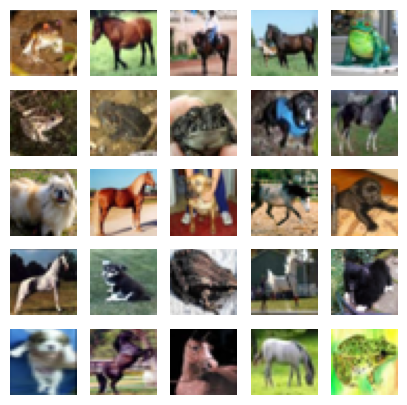

In [6]:
show_examples(X_train)

In [7]:
# util functions
def generate_ts(num):
  # generates random timesteps
  return np.random.randint(0, timesteps, size=num)

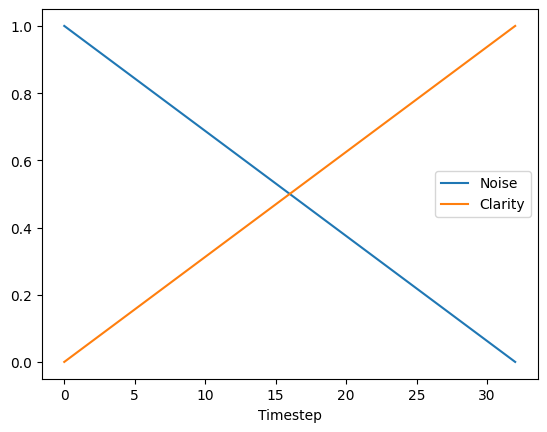

In [8]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.xlabel('Timestep')
plt.legend();

In [9]:
# forward noise
def forward_noise(img, ts):
  # slowly adds noise to images
  current_time = time_bar[ts]
  next_time = time_bar[ts + 1]

  noise = np.random.normal(size=img.shape)  # noise mask

  new_shape = tuple([-1] + [1 for _ in range(img.ndim - 1)])
  current_time = current_time.reshape(new_shape)
  next_time = next_time.reshape(new_shape)

  current_img = img * (1 - current_time) + noise * current_time
  next_img = img * (1 - next_time) + noise * next_time
  return current_img, next_img

In [10]:
ts = generate_ts(num_images)
current_imgs, next_imgs = forward_noise(X_train[:num_images], ts)

In [11]:
class UNetBlock(keras.layers.Layer):
  def __init__(self, filters=128, kernel_size=3, activation='relu'):
    super().__init__()
    self.filters = filters
    self.kernel_size = kernel_size
    self.activation = activation
    self.conv2d1 = keras.layers.Conv2D(self.filters, kernel_size=self.kernel_size, padding='same')
    self.conv2d2 = keras.layers.Conv2D(self.filters, kernel_size=self.kernel_size, padding='same')
    self.Activation1 = keras.layers.Activation(self.activation)
    self.Activation2 = keras.layers.Activation(self.activation)
    self.Activation3 = keras.layers.Activation(self.activation)
    self.dense = keras.layers.Dense(self.filters, activation=self.activation)
    self.reshape = keras.layers.Reshape((1, 1, self.filters))
    self.normalization = keras.layers.LayerNormalization()

  def call(self, x_img, x_ts):
    x_param = self.conv2d1(x_img)
    x_param = self.Activation1(x_param)

    time_param = self.dense(x_ts)
    time_param = self.Activation2(time_param)
    time_param = self.reshape(time_param)

    x_param = x_param * time_param

    x_out = self.conv2d2(x_img)
    x_out = x_out + x_param
    x_out = self.normalization(x_out)
    x_out = self.Activation3(x_out)

    return x_out

In [12]:
class MLPBlock(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.flatten = keras.layers.Flatten()
    self.concat = keras.layers.Concatenate()
    self.dense128 = keras.layers.Dense(128)
    self.normalization1 = keras.layers.LayerNormalization()
    self.normalization2 = keras.layers.LayerNormalization()
    self.activation1 = keras.layers.Activation('relu')
    self.activation2 = keras.layers.Activation('relu')
    self.dense512 = keras.layers.Dense(512)
    self.reshape = keras.layers.Reshape((4, 4, 32))

  def call(self, x, ts):
    x = self.flatten(x)
    x = self.concat([x, ts])
    x = self.dense128(x)
    x = self.normalization1(x)
    x = self.activation1(x)
    x = self.dense512(x)
    x = self.normalization2(x)
    x = self.activation2(x)
    x = self.reshape(x)
    return x

In [ ]:
def make_model():
  x = x_input = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
  x_ts = x_ts_input = keras.layers.Input(shape=(1,), name='x_ts_input')

  x_ts = keras.layers.Dense(192)(x_ts)
  x_ts = keras.layers.LayerNormalization()(x_ts)
  x_ts = keras.layers.Activation('relu')(x_ts)

  x = x32 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x16 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x8 = UNetBlock()(x, x_ts)
  x = keras.layers.MaxPool2D(2)(x)

  x = x4 = UNetBlock()(x, x_ts)

  x = MLPBlock()(x, x_ts)

  x = keras.layers.Concatenate()([x, x4])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x8])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x16])
  x = UNetBlock()(x, x_ts)
  x = keras.layers.UpSampling2D(2)(x)

  x = keras.layers.Concatenate()([x, x32])
  x = UNetBlock()(x, x_ts)

  x_img = keras.layers.Conv2D(3, kernel_size=1, padding='same', name='image_output')(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.25)(x)

  cls = keras.layers.Dense(3, activation='softmax', name='class_output')(x)

  model = tf.keras.models.Model([x_input, x_ts_input], [x_img, cls])
  return model

In [ ]:
model = make_model()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization_11 (La  (None, 192)                  384       ['dense_12[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 x_input (InputLayer)        [(None, 32, 32, 3)]          0         []                      

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss_func_img = tf.keras.losses.MeanAbsoluteError()
loss_func_cls = tf.keras.losses.SparseCategoricalCrossentropy()
losses = {'image_output': loss_func_img, 'class_output': loss_func_cls}
weights = {'image_output': 1., 'class_output': 0.5}
model.compile(loss=losses, optimizer=optimizer, loss_weights=weights)

In [18]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        [x, cls] = model.predict([x, np.full((8),  t)], verbose=0)
        cls = tf.math.argmax(cls, axis=1)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(scale(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

In [19]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
    for i in trange(timesteps):
        t = i
        [x, cls] = model.predict([x, np.full((32), t)], verbose=0)
    cls = tf.math.argmax(cls, axis=1)
    return x, cls

In [20]:
def train_one(x_img, cls):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch(x=[x_a, x_ts], y={'image_output': x_b, 'class_output': cls}, return_dict=True)
    return loss

In [21]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            idx = np.random.randint(len(X_train), size=BATCH_SIZE)
            x_img = X_train[idx]
            cls = y_train[idx].squeeze()
            loss = train_one(x_img, cls)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'image_loss: {loss["image_output_loss"]:.5f}, class_loss: {loss["class_output_loss"]:.5f}, p: {pg:.2f}%')

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.005>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

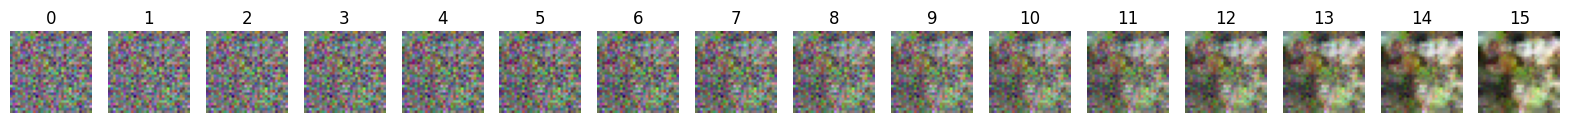

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0045>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

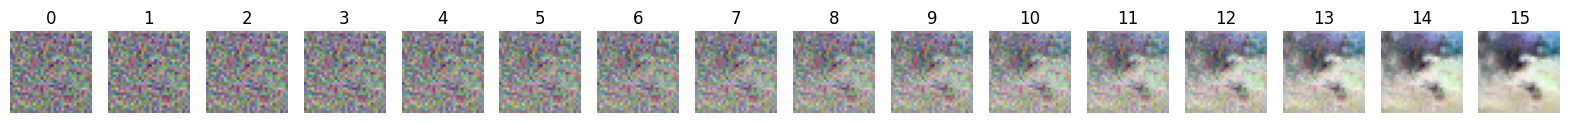

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0040499996>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

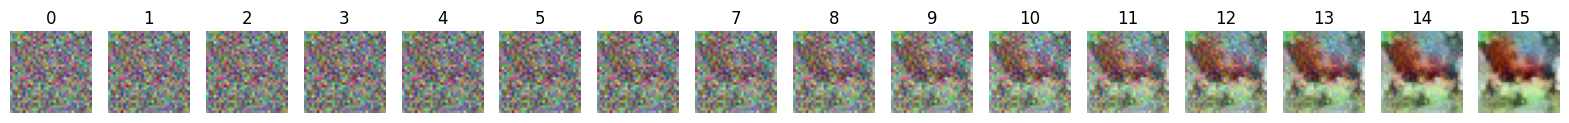

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0036449996>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

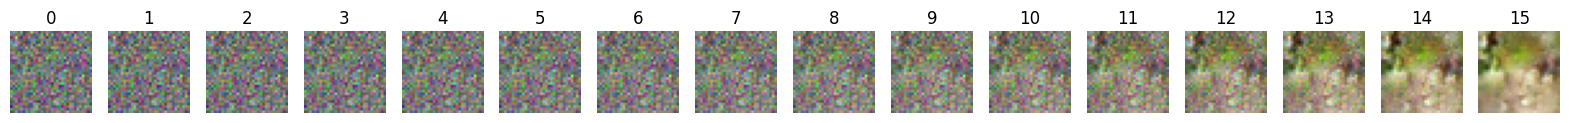

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0032804995>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

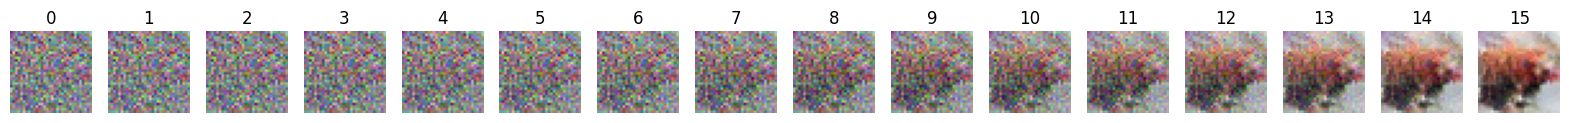

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0029524495>


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(32,), dtype=int64)


  0%|          | 0/32 [00:00<?, ?it/s]

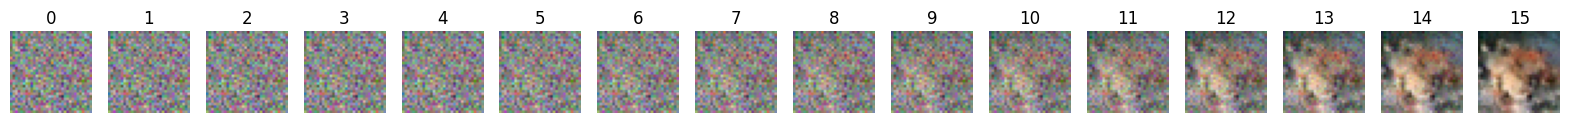

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0026572044>


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
for _ in range(8):
    print(model.optimizer.learning_rate)
    train()

    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.00005, model.optimizer.learning_rate * 0.9)

    # show result
    [x, cls] = predict()
    print(cls)
    predict_step()
    plt.show()

In [1]:
model.save('DiffusionModel.keras')

NameError: name 'model' is not defined

In [16]:
drive.mount('/content/drive')

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/DiffusionModel.keras'
with custom_object_scope({'MLPBlock': MLPBlock, 'UNetBlock': UNetBlock}):
    model = tf.keras.models.load_model(model_path)

#model = tf.keras.models.load_model('DiffusionModel.keras')

# Show the model architecture
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 192)                  384       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 192)                  384       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                

In [ ]:
def predict(X):
    predictions = []
    batch_size = 64  # Adjust the batch size as needed
    for i in trange(0, len(X), batch_size):
        batch_x = X[i:i+batch_size]
        batch_cls = np.full((len(batch_x),), 32)
        for _ in range(timesteps):
            [batch_x, cls] = model.predict([batch_x, batch_cls], verbose=0)
        cls = tf.math.argmax(cls, axis=1)
        predictions.extend(cls.numpy())  # Extend the predictions list with the current batch's predictions
    return np.array(predictions, dtype=np.int64)  # Ensure the predictions are of int64 data type


In [ ]:
def f1_score(y_true, y_pred, threshold=0.25):
    threshold = tf.cast(threshold, dtype=tf.float32)  # Ensure threshold is of float32 dtype
    y_true_bin = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred_bin = tf.cast(y_pred > threshold, dtype=tf.float32)

    tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, dtype=tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true_bin) * y_pred_bin, dtype=tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), dtype=tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    return f1


def accuracy(y_true, y_pred, threshold=0.25):
    threshold = tf.cast(threshold, dtype=tf.float32)
    y_true_bin = tf.cast(y_true > threshold, dtype=tf.float32)
    y_pred_bin = tf.cast(y_pred > threshold, dtype=tf.float32)
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(y_true_bin, y_pred_bin), dtype=tf.int32))
    total_predictions = tf.reduce_prod(tf.shape(y_true_bin))

    return correct_predictions / total_predictions

def test(y_pred, y_val):
    y_vals = y_val.ravel()

    f1 = f1_score(y_vals, y_pred)
    print("F1 Score:", f1)
    acc = accuracy(y_vals, y_pred)

    # Calculate ROC curve
    n_classes = np.unique(y_test).shape[0]
    for class_idx in range(n_classes):
      y_true_binary = (y_test == class_idx).astype(float)
      fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred)
      roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("F1 Score:", f1)
    print("Accuracy:", acc)

In [ ]:
y_pred = predict(X_test)

  0%|          | 0/16 [00:00<?, ?it/s]

F1 Score: tf.Tensor(0.8142292, shape=(), dtype=float32)


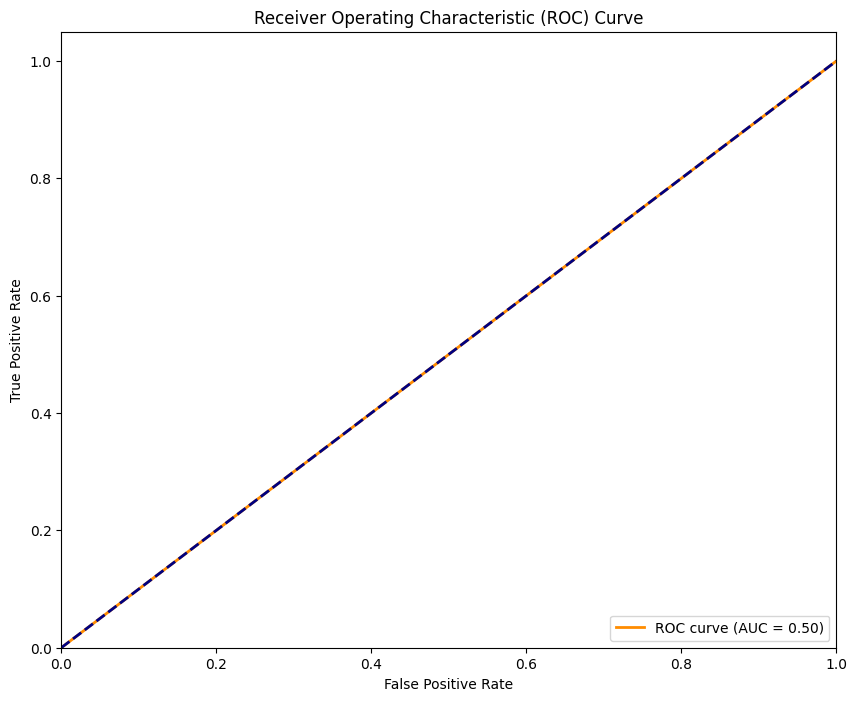

F1 Score: tf.Tensor(0.8142292, shape=(), dtype=float32)
Accuracy: tf.Tensor(0.6866666666666666, shape=(), dtype=float64)


In [ ]:
test(y_pred, y_test)